# Feature Engineering & Embeddings
Objective: Transform enriched metadata into ML-ready features and generate semantic embeddings for the RL environment.
Outputs:

data/processed/features.parquet
artifacts/preprocessing/scaler.pkl
artifacts/indexes/model_embeddings.faiss
artifacts/indexes/model_id_mapping.json

In [ ]:
import sys
sys.path.append('/content/colab_src')

import importlib
import feature_engine
importlib.reload(feature_engine)

from feature_engine import RecencyScorer


## 1. Setup & Load Enriched Data

In [ ]:
# Setup & Load Enriched Data
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Add colab_src to path
BASE_DIR = Path("/content/drive/MyDrive/llm-recommender-colab")
sys.path.insert(0, str(BASE_DIR / "colab_src"))

from utils import PathManager, save_json, validate_dataframe
from feature_engine import (
    TextPreprocessor, CostScorer, PopularityScorer,
    RecencyScorer, FeatureScaler, DiversityCalculator
)

# Initialize paths
paths = PathManager(BASE_DIR)

# Load enriched dataset from Sprint 2
enriched_file = paths.PROCESSED_DIR / "hf_models_enriched.parquet"
df = pd.read_parquet(enriched_file)

print(f"✅ Loaded {len(df)} models from Sprint 2")
print(f"   Columns: {len(df.columns)}")
print(f"\nSample data:")
display(df[['model_id', 'num_parameters', 'quantization', 'downloads', 'likes']].head())


✅ Loaded 95 models from Sprint 2
   Columns: 25

Sample data:


,model_id,num_parameters,quantization,downloads,likes
0,openai-community/gpt2,5.0,None,9452248,3042
1,Qwen/Qwen2.5-3B-Instruct,3.0,None,7871619,338
2,openai/gpt-oss-20b,20.0,None,7632636,4017
3,Qwen/Qwen2.5-7B-Instruct,7.0,None,7530449,926
4,Qwen/Qwen3-0.6B,0.6,None,7068572,839


## 2. Text Preprocessing
Clean descriptions, parse tags, and prepare text for embedding.

In [ ]:

# Text Preprocessing
print("Preprocessing text features...")

# Clean descriptions
df['description_clean'] = df['card_description'].apply(
    TextPreprocessor.clean_description
)

# Parse tags from string
df['tags_list'] = df['tags'].apply(TextPreprocessor.parse_tags)

# Combine text features for embedding
df['combined_text'] = df.apply(
    lambda row: TextPreprocessor.combine_text_features(
        description=row['description_clean'],
        tags=row['tags_list'],
        use_cases=row['card_use_cases']
    ),
    axis=1
)

# Check for empty text
empty_text = df['combined_text'].str.len() == 0
print(f"\n✅ Text preprocessing complete")
print(f"   Models with empty text: {empty_text.sum()}")
print(f"   Mean text length: {df['combined_text'].str.len().mean():.0f} chars")

# Show sample
print(f"\nSample combined text:")
for idx, text in df['combined_text'].head(3).items():
    print(f"\n{df.loc[idx, 'model_id']}:")
    print(f"  {text[:150]}...")

Preprocessing text features...

✅ Text preprocessing complete
   Models with empty text: 0
   Mean text length: 457 chars

Sample combined text:

openai-community/gpt2:
  test the whole generation capabilities here pretrained model on english language using a causal language modeling clm objective. it was introduced in ...

Qwen/Qwen2.5-3B-Instruct:
  transformers safetensors qwen2 text-generation chat
 conversational en arxiv:2407.10671 base_model:Qwen/Qwen2.5-3B
 base_model:finetune:Qwen/Qwen2.5-3...

openai/gpt-oss-20b:
  try gpt-oss  guides  model card  openai blog welcome to the gpt-oss series, openais open-weight models designed for powerful reasoning, agentic tasks,...


## 3. Feature Engineering

### 3.1 Cost Score Calculation
Calculate cost based on parameters and quantization level.


Calculating cost scores...
✅ Cost scores calculated

Cost Statistics:
         cost_raw  cost_score
count   86.000000   86.000000
mean    18.193884    0.053879
std     43.837129    0.130710
min      0.124000    0.000000
25%      1.500000    0.004103
50%      6.875000    0.020130
75%     14.000000    0.041374
max    335.500000    1.000000


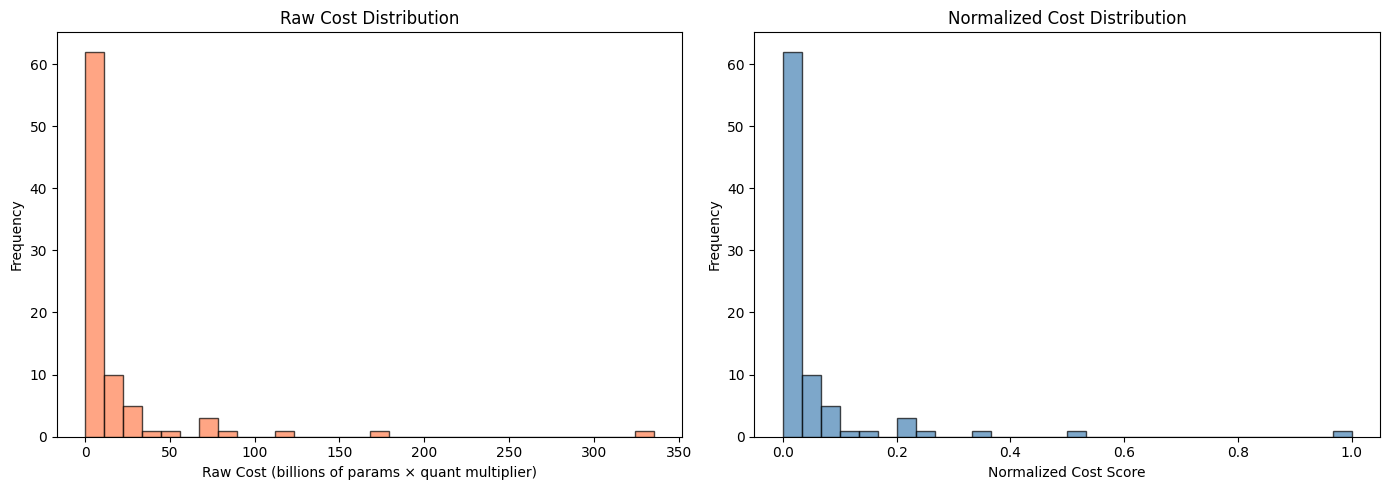


Cost Score Examples:


,model_id,num_parameters,quantization,cost_raw,cost_score
0,openai-community/gpt2,5.0,None,5.0,0.014539
1,Qwen/Qwen2.5-3B-Instruct,3.0,None,3.0,0.008575
2,openai/gpt-oss-20b,20.0,None,20.0,0.059265
3,Qwen/Qwen2.5-7B-Instruct,7.0,None,7.0,0.020502
4,Qwen/Qwen3-0.6B,0.6,None,0.6,0.001419
5,Qwen/Qwen3-4B-Instruct-2507,4.0,None,4.0,0.011557
6,Qwen/Qwen2.5-1.5B-Instruct,1.5,None,1.5,0.004103
7,meta-llama/Llama-3.1-8B-Instruct,8.0,None,8.0,0.023484
8,dphn/dolphin-2.9.1-yi-1.5-34b,34.0,4-bit,8.5,0.024975
9,facebook/opt-125m,175.0,None,175.0,0.521433


In [ ]:
# Cost Score Calculation
print("Calculating cost scores...")

# Calculate raw cost scores
df['cost_raw'] = df.apply(
    lambda row: CostScorer.calculate_cost_score(
        num_parameters=row['num_parameters'],
        quantization=row['quantization']
    ),
    axis=1
)

# Normalize to [0, 1]
df['cost_score'] = CostScorer.normalize_cost_score(df['cost_raw'])

print(f"✅ Cost scores calculated")
print(f"\nCost Statistics:")
print(df[['cost_raw', 'cost_score']].describe())

# Visualize cost distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['cost_raw'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0].set_xlabel('Raw Cost (billions of params × quant multiplier)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Raw Cost Distribution')

axes[1].hist(df['cost_score'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_xlabel('Normalized Cost Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Normalized Cost Distribution')

plt.tight_layout()
plt.show()

# Show examples
print(f"\nCost Score Examples:")
cost_examples = df[['model_id', 'num_parameters', 'quantization', 'cost_raw', 'cost_score']].head(10)
display(cost_examples)

### 3.2 Popularity Score
Combine downloads and likes with logarithmic scaling.

Calculating popularity scores...
✅ Popularity scores calculated

Popularity Statistics:
       popularity_raw  popularity_score
count       95.000000         95.000000
mean        11.485143          0.518185
std          0.952845          0.212124
min          9.157499          0.000000
25%         10.870881          0.381437
50%         11.327937          0.483188
75%         12.220631          0.681921
max         13.649414          1.000000


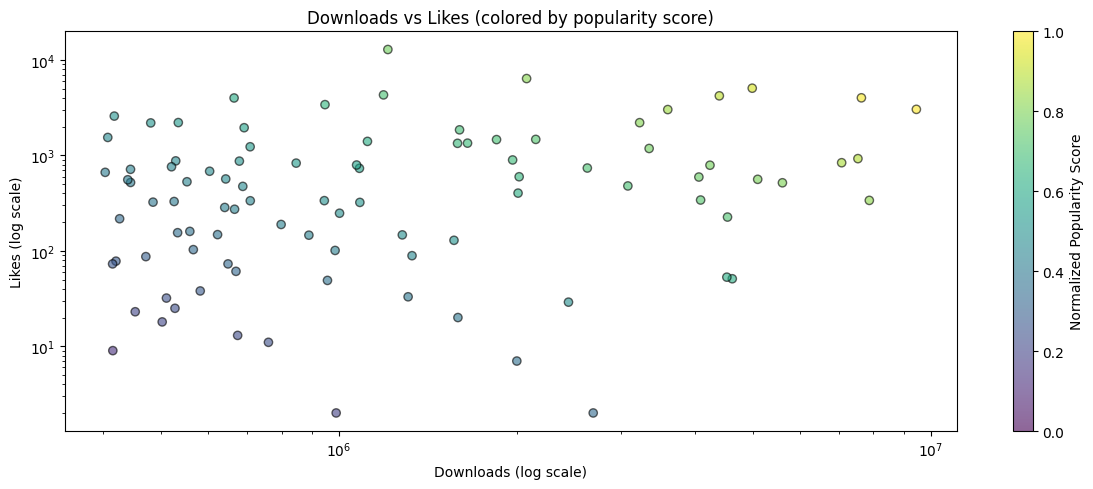

In [ ]:
# Popularity Score
print("Calculating popularity scores...")

# Calculate raw popularity
df['popularity_raw'] = df.apply(
    lambda row: PopularityScorer.calculate_popularity_score(
        downloads=row['downloads'],
        likes=row['likes']
    ),
    axis=1
)

# Normalize
df['popularity_score'] = PopularityScorer.normalize_popularity(df['popularity_raw'])

print(f"✅ Popularity scores calculated")
print(f"\nPopularity Statistics:")
print(df[['popularity_raw', 'popularity_score']].describe())

# Visualize
plt.figure(figsize=(12, 5))
plt.scatter(df['downloads'], df['likes'], c=df['popularity_score'],
           cmap='viridis', alpha=0.6, edgecolors='black')
plt.xlabel('Downloads (log scale)')
plt.ylabel('Likes (log scale)')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='Normalized Popularity Score')
plt.title('Downloads vs Likes (colored by popularity score)')
plt.tight_layout()
plt.show()

### 3.3 Recency Score
Calculate model age and convert to recency score.

Calculating recency scores...
                 created_at days_old  recency_score
0 2022-03-02 23:29:04+00:00     None            0.5
1 2024-09-17 14:08:52+00:00     None            0.5
2 2025-08-04 22:33:29+00:00     None            0.5
3 2024-09-16 11:55:40+00:00     None            0.5
4 2025-04-27 03:40:08+00:00     None            0.5
5 2025-08-05 10:58:03+00:00     None            0.5
6 2024-09-17 14:10:29+00:00     None            0.5
7 2024-07-18 08:56:00+00:00     None            0.5
8 2024-05-18 04:50:56+00:00     None            0.5
9 2022-05-11 08:25:17+00:00     None            0.5

✅ Recency scores calculated

Recency Statistics:
       recency_score
count           95.0
mean             0.5
std              0.0
min              0.5
25%              0.5
50%              0.5
75%              0.5
max              0.5


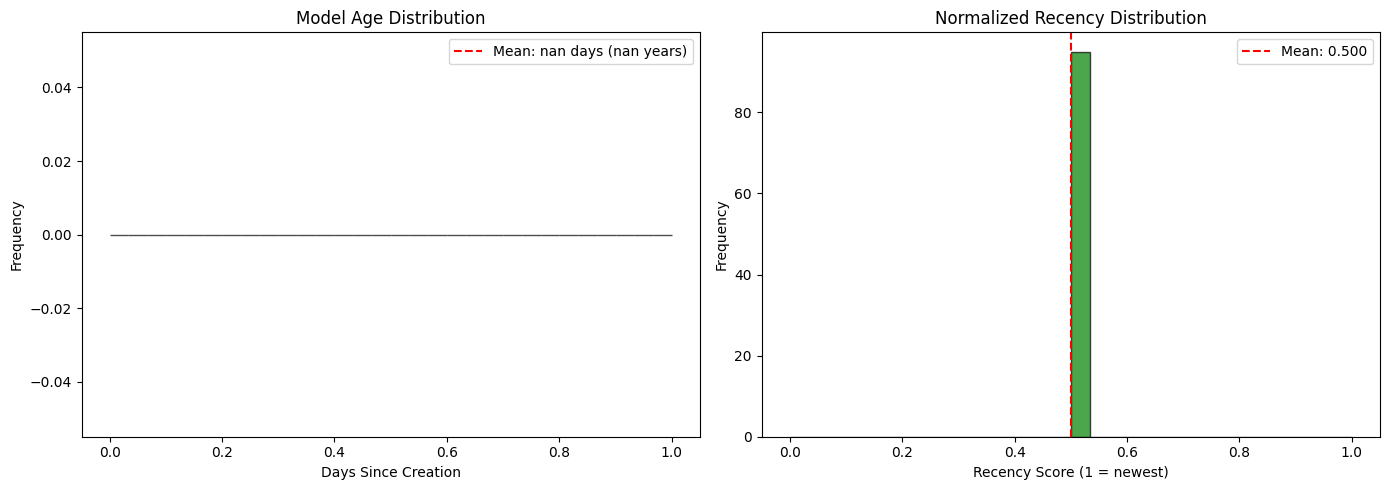


Age Range:
  Newest: nan days (nan years)
  Oldest: nan days (nan years)
  Mean:   nan days (nan years)

Sample Models by Recency:

5 Newest Models:

5 Oldest Models:


In [36]:
# CELL 3.3: Recency Score (FIXED)
print("Calculating recency scores...")

# Calculate days since creation (no capping)
df["days_old"] = df["created_at"].apply(RecencyScorer.calculate_recency_score)
df["recency_score"] = RecencyScorer.normalize_recency(df["days_old"])
print(df[["created_at", "days_old", "recency_score"]].head(10))

# Check for future dates (data quality issue)
future_dates = df[df['days_old'] == 0]
if len(future_dates) > 0:
    print(f"\n⚠️  Found {len(future_dates)} models with future dates:")
    for idx, row in future_dates.head(5).iterrows():
        print(f"   - {row['model_id']}: {row['created_at']}")

# Normalize using actual max (not fixed 5-year cap)
df['recency_score'] = RecencyScorer.normalize_recency(
    df['days_old'],
    use_actual_max=True  # Use dataset's actual age range
)

print(f"\n✅ Recency scores calculated")
print(f"\nRecency Statistics:")
print(df[['days_old', 'recency_score']].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Days old distribution
valid_days = df['days_old'].dropna()
axes[0].hist(valid_days, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0].set_xlabel('Days Since Creation')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Model Age Distribution')
axes[0].axvline(valid_days.mean(), color='red', linestyle='--',
                label=f'Mean: {valid_days.mean():.0f} days ({valid_days.mean()/365:.1f} years)')
axes[0].legend()

# Recency score distribution
axes[1].hist(df['recency_score'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Recency Score (1 = newest)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Normalized Recency Distribution')
axes[1].axvline(df['recency_score'].mean(), color='red', linestyle='--',
                label=f'Mean: {df["recency_score"].mean():.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Show age range
print(f"\nAge Range:")
print(f"  Newest: {valid_days.min():.0f} days ({valid_days.min()/365:.2f} years)")
print(f"  Oldest: {valid_days.max():.0f} days ({valid_days.max()/365:.2f} years)")
print(f"  Mean:   {valid_days.mean():.0f} days ({valid_days.mean()/365:.2f} years)")

# Show examples
print(f"\nSample Models by Recency:")
sample = df[['model_id', 'created_at', 'days_old', 'recency_score']].dropna(subset=['days_old'])
sample_sorted = sample.sort_values('recency_score', ascending=False)

print(f"\n5 Newest Models:")
for idx, row in sample_sorted.head(5).iterrows():
    print(f"  {row['model_id']:45s} | {row['days_old']:4.0f} days | Score: {row['recency_score']:.4f}")

print(f"\n5 Oldest Models:")
for idx, row in sample_sorted.tail(5).iterrows():
    print(f"  {row['model_id']:45s} | {row['days_old']:4.0f} days | Score: {row['recency_score']:.4f}")

### 3.4 Diversity Score
Calculate architecture diversity based on rarity.

Calculating diversity scores...
✅ Diversity scores calculated

Diversity Statistics:
count    95.000000
mean      0.674402
std       0.176199
min       0.500000
25%       0.522727
50%       0.522727
75%       0.738636
max       0.988636
Name: diversity_score, dtype: float64

Architecture Diversity (higher = rarer):


,diversity_score,count
model_type,,
bloom,0.988636,1
t5,0.988636,1
opt,0.988636,1
gemma,0.965909,3
mistral,0.965909,3
phi,0.931818,6
gpt,0.909091,8
llama,0.738636,23
qwen,0.522727,42


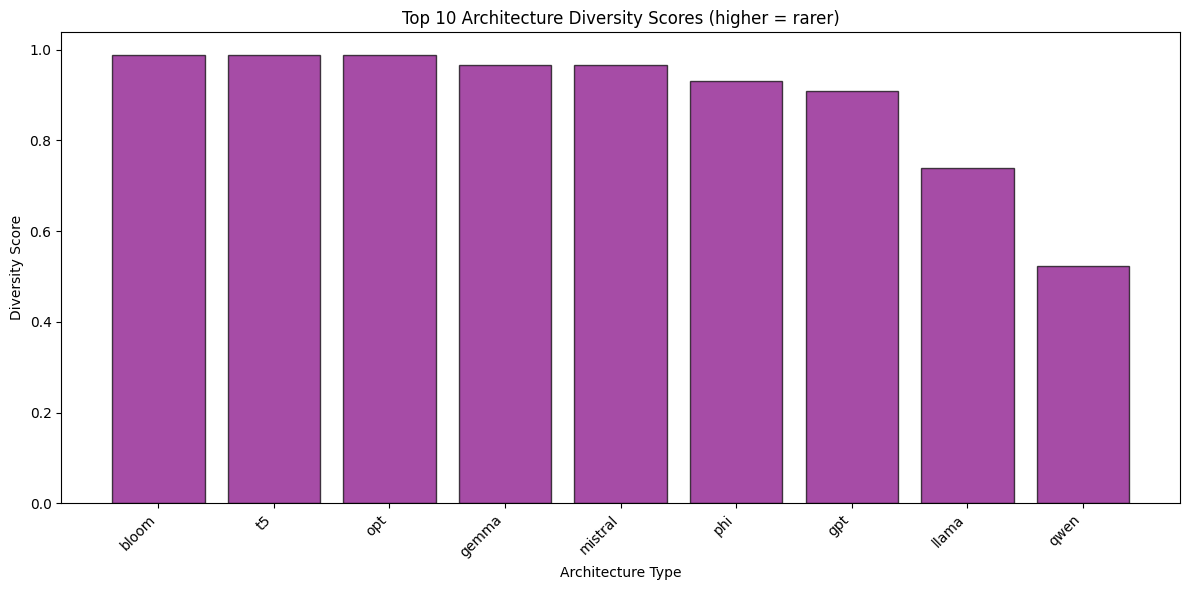

In [ ]:
# Diversity Score
print("Calculating diversity scores...")

# Get architecture counts
arch_counts = df['model_type'].value_counts().to_dict()

# Calculate diversity for each model
df['diversity_score'] = df['model_type'].apply(
    lambda x: DiversityCalculator.calculate_architecture_diversity(x, arch_counts)
)

print(f"✅ Diversity scores calculated")
print(f"\nDiversity Statistics:")
print(df['diversity_score'].describe())

# Show architecture diversity
arch_diversity = df.groupby('model_type').agg({
    'diversity_score': 'first',
    'model_id': 'count'
}).rename(columns={'model_id': 'count'}).sort_values('diversity_score', ascending=False)

print(f"\nArchitecture Diversity (higher = rarer):")
display(arch_diversity.head(10))

# Visualize
plt.figure(figsize=(12, 6))
plt.bar(arch_diversity.index[:10], arch_diversity['diversity_score'][:10],
        edgecolor='black', alpha=0.7, color='purple')
plt.xlabel('Architecture Type')
plt.ylabel('Diversity Score')
plt.title('Top 10 Architecture Diversity Scores (higher = rarer)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 4. Feature Normalization
Normalize all engineered features to [0, 1] range.

In [ ]:
# Feature Normalization
print("Normalizing all features...")

# Define feature columns
feature_cols = ['cost_score', 'popularity_score', 'recency_score', 'diversity_score']

# Create scaler
scaler = FeatureScaler()
scaler.fit(df, feature_cols)

# Transform features (already normalized, but good for consistency)
df_normalized = scaler.transform(df[feature_cols])

# Add normalized features to dataframe
for col in feature_cols:
    df[f'{col}_normalized'] = df_normalized[col]

print(f"✅ Features normalized")
print(f"\nNormalized Feature Statistics:")
print(df[[f'{col}_normalized' for col in feature_cols]].describe())

# Save scaler
scaler_file = paths.PREPROCESSING_DIR / "feature_scaler.pkl"
scaler.save(scaler_file)
print(f"\n✅ Scaler saved to: {scaler_file}")


Normalizing all features...
✅ Features normalized

Normalized Feature Statistics:
       cost_score_normalized  popularity_score_normalized  \
count              86.000000                    95.000000   
mean                0.053879                     0.518185   
std                 0.130710                     0.212124   
min                 0.000000                     0.000000   
25%                 0.004103                     0.381437   
50%                 0.020130                     0.483188   
75%                 0.041374                     0.681921   
max                 1.000000                     1.000000   

       recency_score_normalized  diversity_score_normalized  
count                      95.0                   95.000000  
mean                        0.5                    0.356916  
std                         0.0                    0.360593  
min                         0.5                    0.000000  
25%                         0.5                    0.04651

## 5. Generate Embeddings
Use sentence-transformers to create semantic embeddings.
Note: This step requires ~2-3 minutes for 100 models.

In [ ]:
# Generate Embeddings
print("="*60)
print("GENERATING EMBEDDINGS")
print("="*60)
print("This may take 2-3 minutes for 100 models...")
print()

# Install sentence-transformers if needed
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    print("Installing sentence-transformers...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "sentence-transformers"])
    from sentence_transformers import SentenceTransformer

# Load model (lightweight and fast)
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
print(f"Loading embedding model: {model_name}")
embedding_model = SentenceTransformer(model_name)

print(f"✅ Model loaded")
print(f"   Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")

# Generate embeddings
texts = df['combined_text'].tolist()
print(f"\nGenerating embeddings for {len(texts)} models...")

embeddings = embedding_model.encode(
    texts,
    show_progress_bar=True,
    batch_size=32
)

print(f"\n✅ Embeddings generated")
print(f"   Shape: {embeddings.shape}")

# Add embeddings to dataframe (as list for now)
df['embedding'] = list(embeddings)

# Save embeddings separately as numpy array
embeddings_file = paths.INDEXES_DIR / "model_embeddings.npy"
np.save(embeddings_file, embeddings)
print(f"✅ Embeddings saved to: {embeddings_file}")


GENERATING EMBEDDINGS
This may take 2-3 minutes for 100 models...

Loading embedding model: sentence-transformers/all-MiniLM-L6-v2
✅ Model loaded
   Embedding dimension: 384

Generating embeddings for 95 models...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


✅ Embeddings generated
   Shape: (95, 384)
✅ Embeddings saved to: /content/drive/MyDrive/llm-recommender-colab/artifacts/indexes/model_embeddings.npy


## 6. Build FAISS Index
Create vector index for fast similarity search.

In [ ]:
# Build FAISS Index
print("="*60)
print("BUILDING FAISS INDEX")
print("="*60)

# Install faiss if needed
try:
    import faiss
except ImportError:
    print("Installing faiss-cpu...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "faiss-cpu"])
    import faiss

# Create FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)  # L2 distance (Euclidean)

# Add embeddings to index
index.add(embeddings.astype('float32'))

print(f"✅ FAISS index built")
print(f"   Index type: L2 (Euclidean distance)")
print(f"   Dimension: {dimension}")
print(f"   Total vectors: {index.ntotal}")

# Save FAISS index
index_file = paths.INDEXES_DIR / "model_embeddings.faiss"
faiss.write_index(index, str(index_file))
print(f"✅ FAISS index saved to: {index_file}")

# Test similarity search
print(f"\n{'='*60}")
print("TEST SIMILARITY SEARCH")
print(f"{'='*60}")

# Search for similar models to the first one
query_idx = 0
query_model = df.iloc[query_idx]['model_id']
query_embedding = embeddings[query_idx:query_idx+1].astype('float32')

# Find 5 most similar models
k = 5
distances, indices = index.search(query_embedding, k)

print(f"\nQuery model: {query_model}")
print(f"\nTop {k} most similar models:")
for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
    similar_model = df.iloc[idx]['model_id']
    print(f"  {i+1}. {similar_model} (distance: {dist:.4f})")


BUILDING FAISS INDEX
✅ FAISS index built
   Index type: L2 (Euclidean distance)
   Dimension: 384
   Total vectors: 95
✅ FAISS index saved to: /content/drive/MyDrive/llm-recommender-colab/artifacts/indexes/model_embeddings.faiss

TEST SIMILARITY SEARCH

Query model: openai-community/gpt2

Top 5 most similar models:
  1. openai-community/gpt2 (distance: 0.0000)
  2. openai-community/gpt2-large (distance: 0.4330)
  3. openai-community/gpt2-medium (distance: 0.4330)
  4. Qwen/Qwen2-0.5B (distance: 0.5471)
  5. bigscience/bloomz-560m (distance: 0.6283)


## 7. Quality Validation
Verify feature distributions and embedding quality.

FEATURE QUALITY VALIDATION

Feature Completeness:
  cost_score               : 9 nulls, 0 infs
  popularity_score         : 0 nulls, 0 infs
  recency_score            : 0 nulls, 0 infs
  diversity_score          : 0 nulls, 0 infs

Feature Correlations:


,cost_score,popularity_score,recency_score,diversity_score
cost_score,1.000000,0.104903,NaN,-0.005913
popularity_score,0.104903,1.000000,NaN,0.047718
recency_score,NaN,NaN,NaN,NaN
diversity_score,-0.005913,0.047718,NaN,1.000000


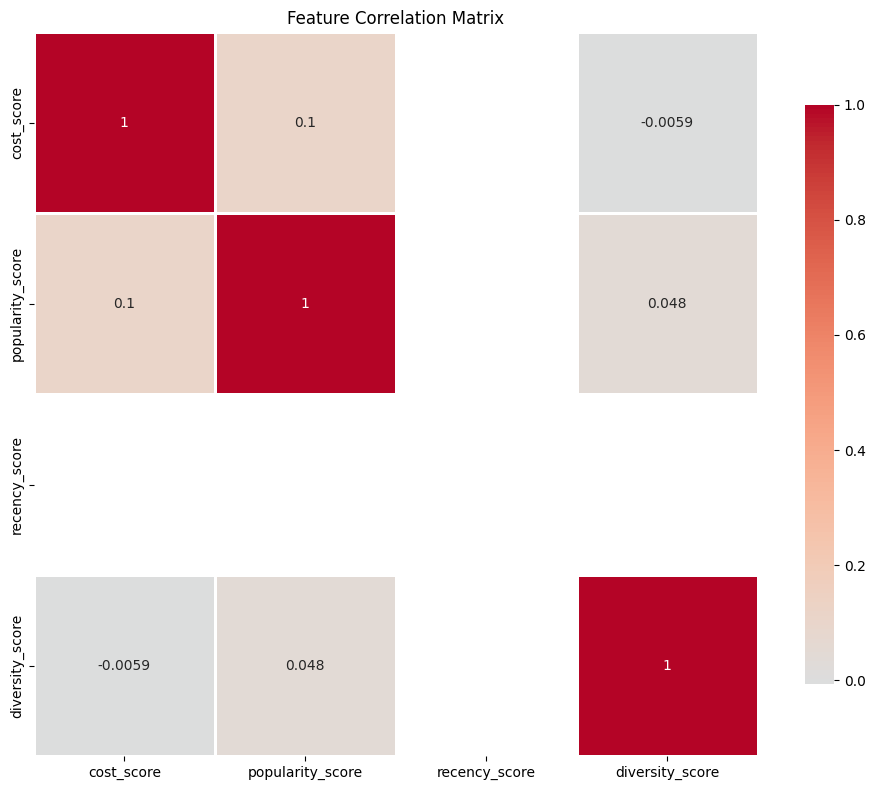

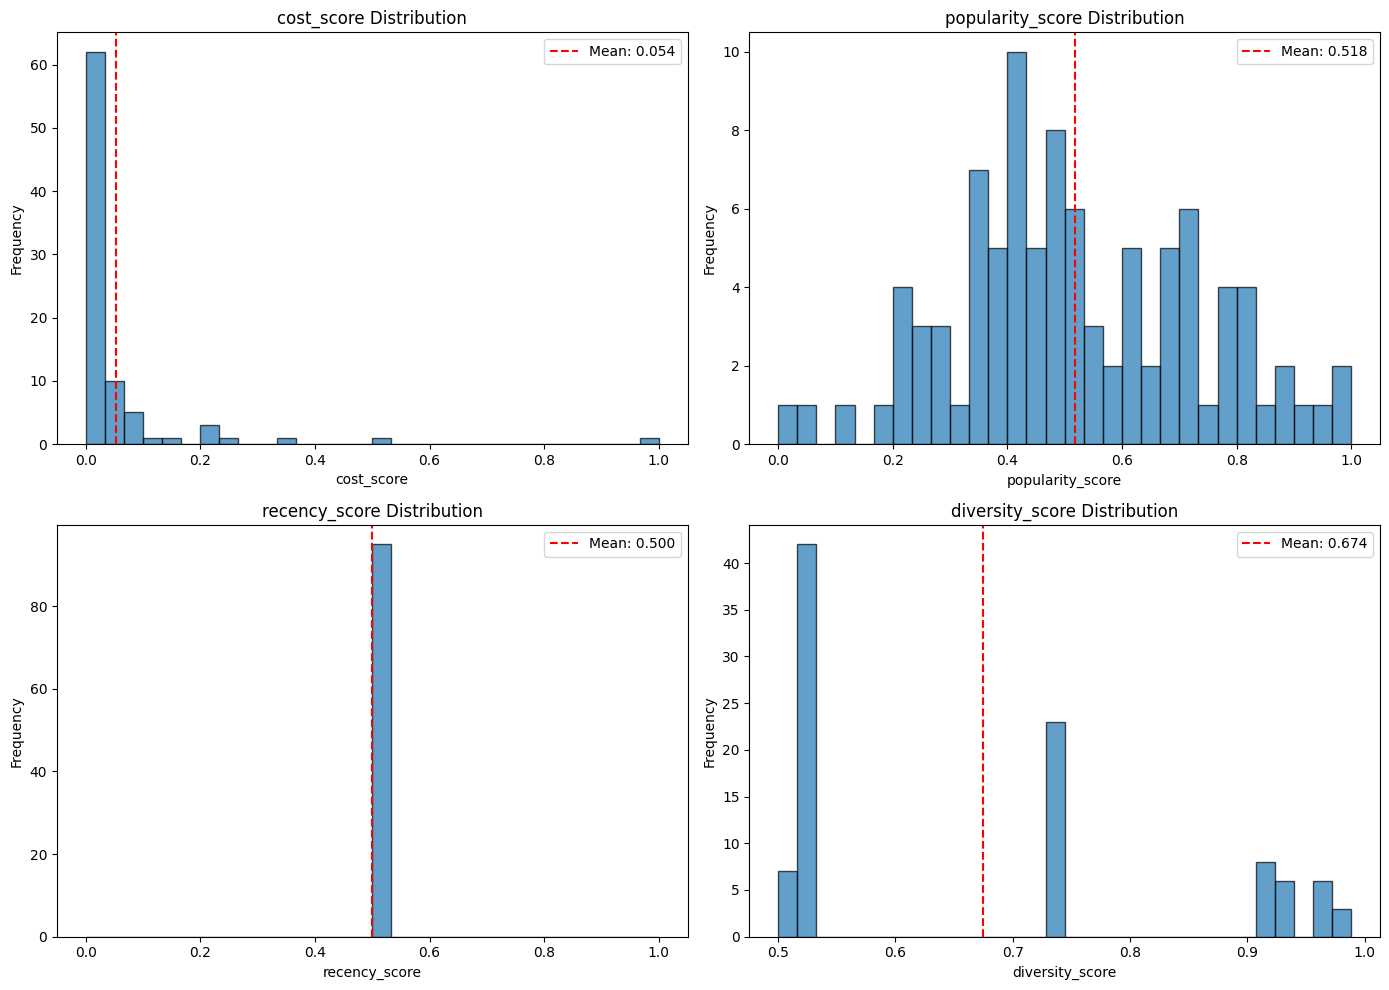


EMBEDDING QUALITY
Embedding shape: (95, 384)
Mean norm: 1.0000
Std norm: 0.0000


In [ ]:
# Quality Validation
print("="*60)
print("FEATURE QUALITY VALIDATION")
print("="*60)

# Check for NaN/Inf in features
feature_cols_all = ['cost_score', 'popularity_score', 'recency_score', 'diversity_score']

print("\nFeature Completeness:")
for col in feature_cols_all:
    null_count = df[col].isna().sum()
    inf_count = np.isinf(df[col]).sum()
    print(f"  {col:25s}: {null_count} nulls, {inf_count} infs")

# Feature correlation matrix
print("\nFeature Correlations:")
corr_matrix = df[feature_cols_all].corr()
display(corr_matrix)

# Visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Feature distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, col in enumerate(feature_cols_all):
    axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].axvline(df[col].mean(), color='red', linestyle='--',
                      label=f'Mean: {df[col].mean():.3f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

# Embedding quality check
print(f"\n{'='*60}")
print("EMBEDDING QUALITY")
print(f"{'='*60}")
print(f"Embedding shape: {embeddings.shape}")
print(f"Mean norm: {np.linalg.norm(embeddings, axis=1).mean():.4f}")
print(f"Std norm: {np.linalg.norm(embeddings, axis=1).std():.4f}")



## 8. Save All Artifacts

In [ ]:
# Save All Artifacts
print("="*60)
print("SAVING ARTIFACTS")
print("="*60)

# Prepare features dataframe for export
feature_columns = [
    'model_id', 'author', 'model_type', 'license',
    'downloads', 'likes', 'created_at',
    'num_parameters', 'quantization', 'model_size_category',
    'description_clean', 'combined_text',
    'cost_score', 'popularity_score', 'recency_score', 'diversity_score',
    'cost_raw', 'popularity_raw', 'days_old'
]

df_features = df[feature_columns].copy()

# Save features (without embeddings to keep file small)
features_file = paths.PROCESSED_DIR / "features.parquet"
df_features.to_parquet(features_file, index=False)

print(f"✅ Features saved to: {features_file}")
print(f"   File size: {features_file.stat().st_size / 1024:.2f} KB")

# Save model ID mapping (for FAISS index lookup)
model_id_mapping = {
    idx: model_id
    for idx, model_id in enumerate(df['model_id'].tolist())
}

mapping_file = paths.INDEXES_DIR / "model_id_mapping.json"
save_json(model_id_mapping, mapping_file)
print(f"✅ Model ID mapping saved to: {mapping_file}")

# Save feature engineering summary
summary = {
    'metadata': {
        'created_at': pd.Timestamp.now().isoformat(),
        'total_models': len(df),
        'embedding_dimension': int(embeddings.shape[1]),
        'embedding_model': model_name
    },
    'features': {
        col: {
            'mean': float(df[col].mean()),
            'std': float(df[col].std()),
            'min': float(df[col].min()),
            'max': float(df[col].max()),
            'null_count': int(df[col].isna().sum())
        }
        for col in feature_cols_all
    },
    'text_stats': {
        'mean_text_length': float(df['combined_text'].str.len().mean()),
        'empty_text_count': int((df['combined_text'].str.len() == 0).sum())
    }
}

summary_file = paths.PROCESSED_DIR / "feature_summary.json"
save_json(summary, summary_file)
print(f"✅ Summary saved to: {summary_file}")

# List all artifacts
print(f"\n{'='*60}")
print("SPRINT 3 COMPLETE")
print(f"{'='*60}")
print(f"\n✅ Artifacts Created:")
print(f"   1. Features: {features_file}")
print(f"   2. Embeddings: {embeddings_file}")
print(f"   3. FAISS index: {index_file}")
print(f"   4. Model ID mapping: {mapping_file}")
print(f"   5. Scaler: {scaler_file}")
print(f"   6. Summary: {summary_file}")

print(f"\n📊 Feature Statistics:")
print(f"   Models processed: {len(df)}")
print(f"   Feature dimensions: {len(feature_cols_all)}")
print(f"   Embedding dimensions: {embeddings.shape[1]}")
print(f"   Mean cost score: {df['cost_score'].mean():.3f}")
print(f"   Mean popularity score: {df['popularity_score'].mean():.3f}")
print(f"   Mean recency score: {df['recency_score'].mean():.3f}")

print(f"\nNext: Sprint 4 - Leaderboard Integration")

SAVING ARTIFACTS
✅ Features saved to: /content/drive/MyDrive/llm-recommender-colab/data/processed/features.parquet
   File size: 42.21 KB
✅ Model ID mapping saved to: /content/drive/MyDrive/llm-recommender-colab/artifacts/indexes/model_id_mapping.json
✅ Summary saved to: /content/drive/MyDrive/llm-recommender-colab/data/processed/feature_summary.json

SPRINT 3 COMPLETE

✅ Artifacts Created:
   1. Features: /content/drive/MyDrive/llm-recommender-colab/data/processed/features.parquet
   2. Embeddings: /content/drive/MyDrive/llm-recommender-colab/artifacts/indexes/model_embeddings.npy
   3. FAISS index: /content/drive/MyDrive/llm-recommender-colab/artifacts/indexes/model_embeddings.faiss
   4. Model ID mapping: /content/drive/MyDrive/llm-recommender-colab/artifacts/indexes/model_id_mapping.json
   5. Scaler: /content/drive/MyDrive/llm-recommender-colab/artifacts/preprocessing/feature_scaler.pkl
   6. Summary: /content/drive/MyDrive/llm-recommender-colab/data/processed/feature_summary.json